In [1]:
!pip install scikit-learn
!pip install seaborn
!pip install statsmodels
!pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_csv("merged_levels.csv")

In [4]:
#taking all the overall data
df = df.loc[df["state"]=='Overall']

In [5]:
df.tail()

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,...,discharged_covid,icu_covid,vent_covid,beds_covid,beds_icu_covid,total_child_vax,total_adol_vax,total_adult_vax,total_elderly_vax,MCO
32424,2025-04-15,Overall,102,0,80,77072,0,25,0,17,...,2,0,0,1616,156,0,0,0,0,0
32441,2025-04-16,Overall,104,0,94,77197,0,23,1,22,...,5,0,0,1677,158,0,0,0,0,0
32458,2025-04-17,Overall,101,0,84,77316,0,28,0,26,...,2,0,1,1596,157,0,0,0,0,0
32475,2025-04-18,Overall,95,0,102,77290,0,33,0,23,...,2,0,0,1543,155,0,0,0,0,0
32492,2025-04-19,Overall,47,1,64,77152,0,11,0,11,...,1,0,0,1271,137,0,0,0,0,0


In [6]:
df['date'] = pd.to_datetime(df['date'])

#create lag features
df['cases_lag_1'] = df['cases_new'].shift(1)
df['cases_lag_7'] = df['cases_new'].shift(7)
df['cases_lag_14'] = df['cases_new'].shift(14)

#rolling averages
df['cases_ma_7'] = df['cases_new'].rolling(window=7).mean()

In [7]:
feature_cols = [col for col in df.columns if col not in ['date', 'cases_new','state']]
X = df[feature_cols]
y = df['cases_new']

In [8]:
#Train Test split
total_records = len(df)
train_size = int(0.7 * total_records)
df_sorted = df.sort_values('date').reset_index(drop=True)

train_df = df_sorted.iloc[:train_size].copy()
test_df = df_sorted.iloc[train_size:].copy()

In [9]:
#Training ARIMA model
train_cases = train_df.set_index('date')['cases_new']
arima_model = ARIMA(train_cases,order=(2,1,2))
arima_fitted = arima_model.fit()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [38]:
X_train = train_df[feature_cols]
y_train = train_df['cases_new']
X_test = test_df[feature_cols]
y_test = test_df['cases_new']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=200, max_depth = 10, random_state = 42)
rf_model.fit(X_train_scaled, y_train)

# Get feature names from the original DataFrame
feature_names = X_train.columns.tolist()
print(feature_names)
print(len(feature_names))


['cases_import', 'cases_recovered', 'cases_active', 'cases_cluster', 'cases_unvax', 'cases_pvax', 'cases_fvax', 'cases_boost', 'daily_partial_child', 'daily_full_child', 'daily_booster_child', 'daily_booster2_child', 'daily_partial_adolescent', 'daily_full_adolescent', 'daily_booster_adolescent', 'daily_booster2_adolescent', 'daily_partial_adult', 'daily_full_adult', 'daily_booster_adult', 'daily_booster2_adult', 'daily_partial_elderly', 'daily_full_elderly', 'daily_booster_elderly', 'daily_booster2_elderly', 'admitted_covid', 'discharged_covid', 'icu_covid', 'vent_covid', 'beds_covid', 'beds_icu_covid', 'total_child_vax', 'total_adol_vax', 'total_adult_vax', 'total_elderly_vax', 'MCO', 'cases_lag_1', 'cases_lag_7', 'cases_lag_14', 'cases_ma_7']
39


In [11]:
#Predictions on test data
print(f"Forecasting {len(test_df)} steps with ARIMA...")
arima_pred = arima_fitted.forecast(steps=len(test_df))

rf_pred = rf_model.predict(X_test_scaled)
print(f"Random Forest prediction shape: {rf_pred.shape}")

Forecasting 574 steps with ARIMA...
Random Forest prediction shape: (574,)


In [12]:
import joblib

# Save the better performing Random Forest model
joblib.dump(rf_model, "random_forest_model_better.pkl")
print("✅ Model saved as random_forest_model_better.pkl")


✅ Model saved as random_forest_model_better.pkl


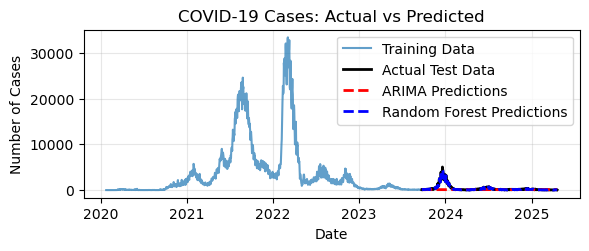

In [13]:
#Time series with predictions
plt.subplot(2, 1, 1)
plt.plot(train_df['date'], train_df['cases_new'], label='Training Data', alpha=0.7)
plt.plot(test_df['date'], y_test, label='Actual Test Data', color='black', linewidth=2)
plt.plot(test_df['date'], arima_pred, label='ARIMA Predictions', color='red', linestyle='--', linewidth=2)
plt.plot(test_df['date'], rf_pred, label='Random Forest Predictions', color='blue', linestyle='--', linewidth=2)
plt.title('COVID-19 Cases: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True, alpha=0.3)


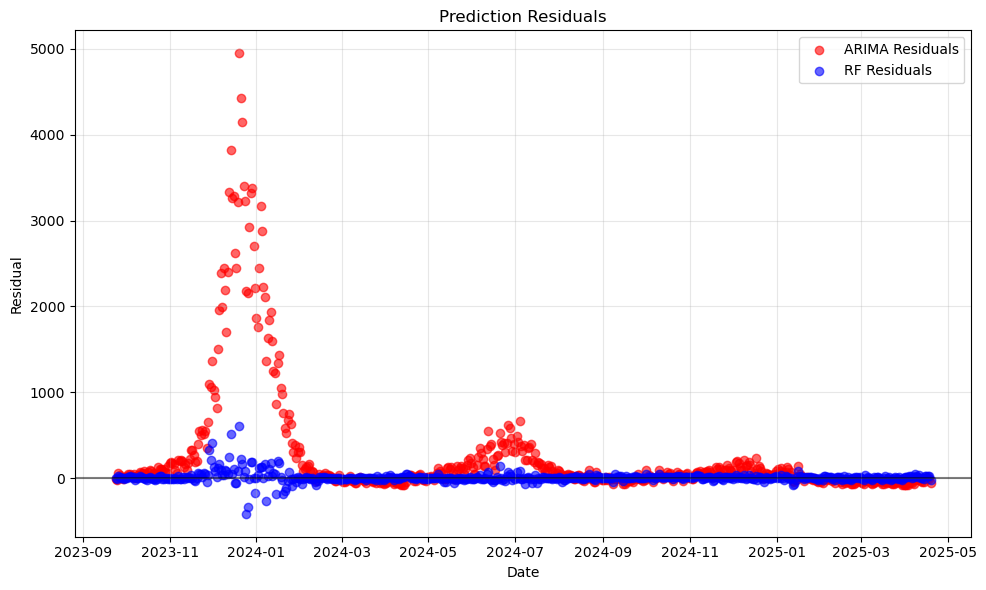

In [14]:
#residual plot
arima_residuals = pd.Series(
    y_test.values - arima_pred,
    index=test_df['date']
)
rf_residuals    = pd.Series(
    y_test.values - rf_pred,
    index=test_df['date']
)

# 3. Plot
plt.figure(figsize=(10,6))
plt.scatter(arima_residuals.index, arima_residuals,
            label='ARIMA Residuals', color='red',   alpha=0.6)
plt.scatter(rf_residuals.index,    rf_residuals,
            label='RF Residuals',    color='blue',  alpha=0.6)
plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.title('Prediction Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Evaluate function for consistency
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {
        "Model": name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R²": round(r2, 3)
    }

# Collect results
results = []
results.append(evaluate_model("ARIMA", y_test, arima_pred))
results.append(evaluate_model("Random Forest", y_test, rf_pred))

# Display as DataFrame
df_results = pd.DataFrame(results)
display(df_results)


,Model,MAE,RMSE,R²
0,ARIMA,293.02,754.27,-0.148
1,Random Forest,26.76,62.29,0.992


Model Evaluation Summary

Random Forest outperforms ARIMA by a large margin in all three metrics.

ARIMA’s R² is negative, which indicates that it's performing worse than simply predicting the mean.

Random Forest shows very low error (MAE and RMSE) and very high R² (0.99), indicating excellent fit and predictive power.
Hence, using Random forest for deployment. 

# 📌 Model Evaluation Summary

from IPython.display import Markdown

summary = """
### ✅ Model Evaluation Summary

After comparing both models — ARIMA and Random Forest — the results clearly show that **Random Forest significantly outperforms ARIMA** across all evaluation metrics:

| Model           | MAE    | RMSE     | R² Score     |
|----------------|--------|----------|--------------|
| **ARIMA**       | 293.02 | 754.27   | **–0.15**     |
| **Random Forest** | 26.76  | 62.29    | **0.99 (Excellent!)** |

#### 🔍 Interpretation:
- **ARIMA** performed poorly, with a **negative R²**, indicating it performed worse than a simple mean predictor.
- **Random Forest** had low error and an excellent **R² score**, making it a much more reliable model for forecasting daily new COVID-19 cases.

✅ **Final Decision**: Proceed with **Random Forest** as the chosen model for deployment and future analysis.
"""

display(Markdown(summary))
